**Modules used...**

In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import GradientBoostingClassifier
%config InlineBackend.figure_format='retina'

# Prepare the data for the model

In [7]:
X_train = pd.read_csv('data/train_features.csv')
X_test = pd.read_csv('data/test_features.csv')
y_train = pd.read_csv('data/train_labels.csv')['charged_off']
sample_submission = pd.read_csv('data/sample_submission.csv')

X_train.shape, X_test.shape, y_train.shape

((1309457, 103), (26724, 103), (1309457,))

In [9]:
def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=40000, test_size=40000,
    random_state=42, stratify=y_train)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40000, 103), (40000, 103), (40000,), (40000,))

In [11]:
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)
X_train.shape, X_val.shape, X_test.shape

((40000, 98), (40000, 98), (26724, 98))

# Train and score the model

TPOTClassifier performs an intelligent search over machine learning pipelines, preprocessors, feature selection techniques, and any other estimator or transformer that follows the scikit-learn API. This helped me determined that this particular XGBoost model was the best after 5 generations of genetic selection. 

In [39]:
# XGBoost

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)

xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=12, 
                     n_estimators=100, n_jobs=-1, subsample=0.9000000000000001)
gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)
y_pred_proba = gb.predict_proba(X_val)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC: 0.7160527061333062


# Interpret the model

In [62]:
df = pd.concat([X_train, y_train],axis=1)
df.corr()['charged_off'].sort_values().tail(5)

acc_open_past_24mths    0.103485
term                    0.189583
int_rate                0.260021
sub_grade               0.267690
charged_off             1.000000
Name: charged_off, dtype: float64

In [85]:
list(df.corr()['charged_off'].sort_values().tail(8).index)[:4]

['funded_amnt', 'dti', 'num_tl_op_past_12m', 'acc_open_past_24mths']

In [63]:
df.corr()['charged_off'].sort_values().head(5)

mort_acc          -0.073440
avg_cur_bal       -0.071411
tot_hi_cred_lim   -0.069684
tot_cur_bal       -0.062740
total_bc_limit    -0.062573
Name: charged_off, dtype: float64

Lets look features that are potentially the most correlated to our target (sub_grade, int_rate, term)

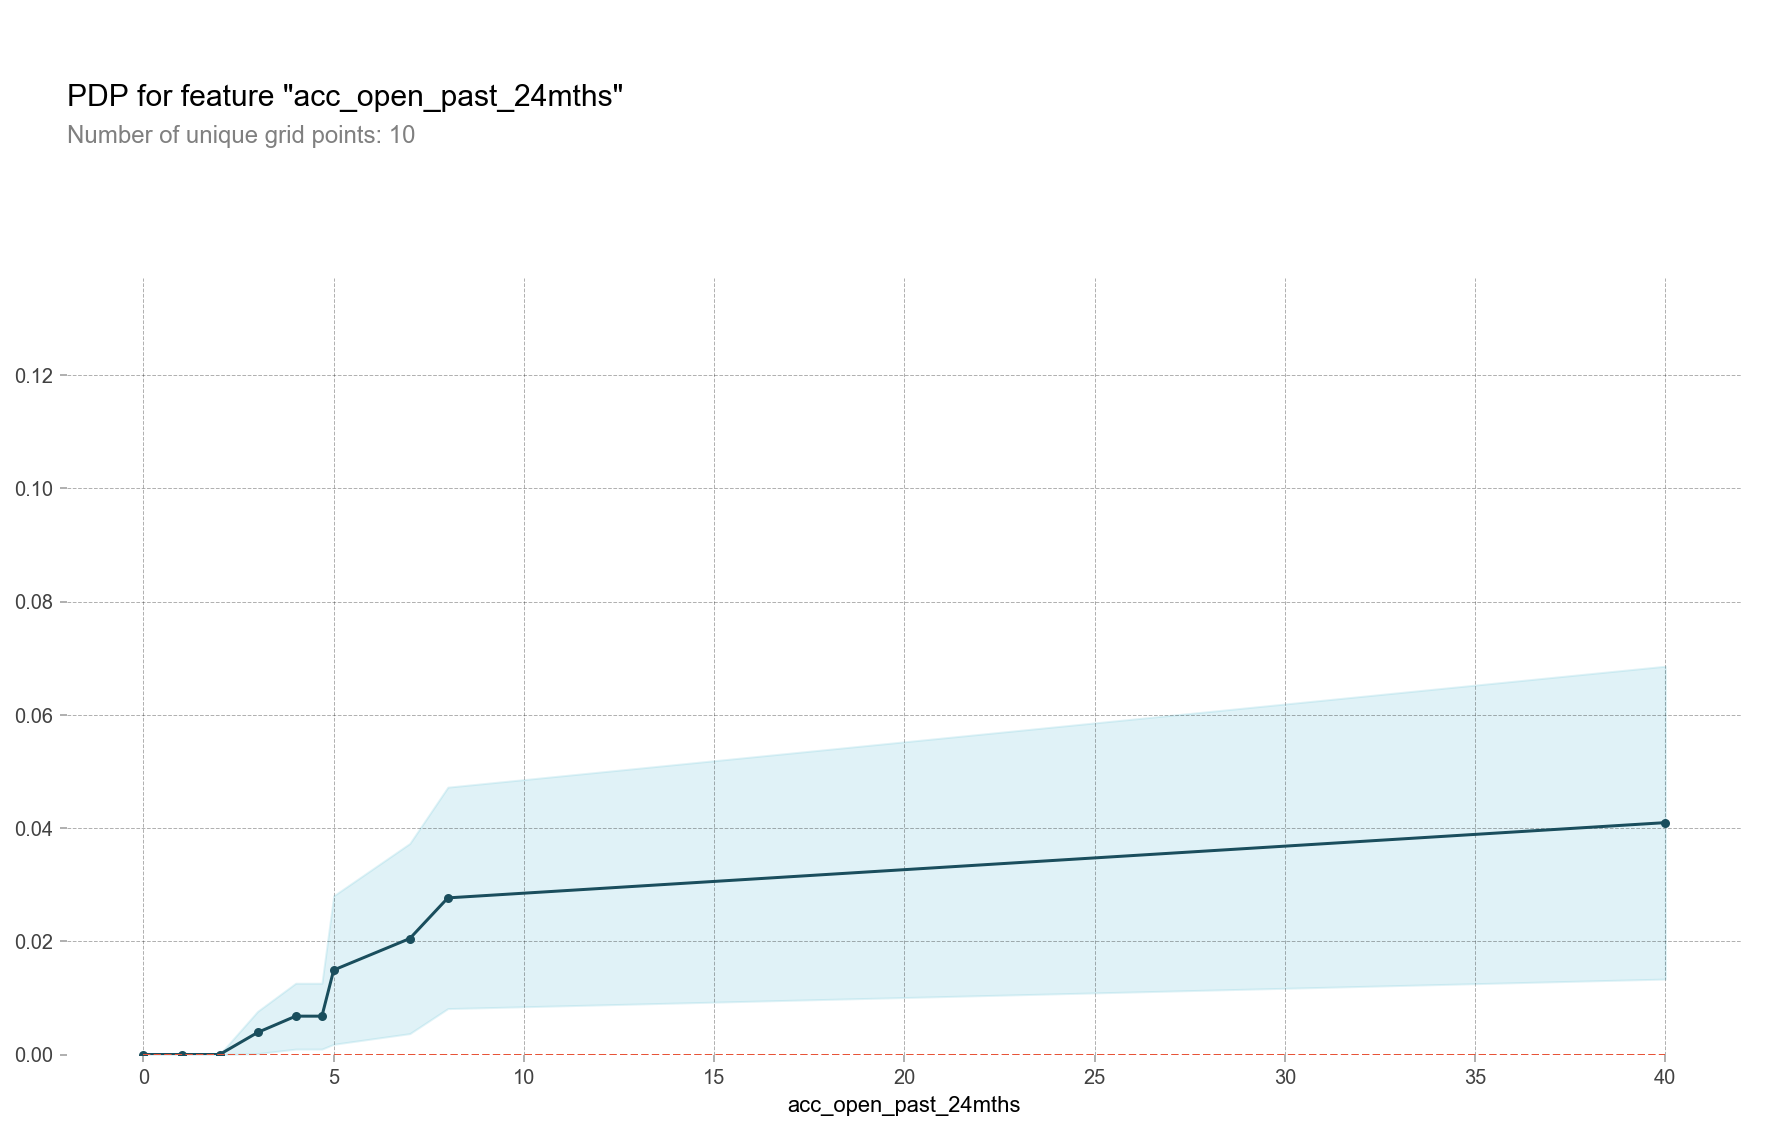

In [69]:
# Partial dependence plot

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

feature='acc_open_past_24mths'
pdp_isolated = pdp_isolate(model=gb, dataset=X_val,
                           model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

This partial dependece plot tells us that after a customer has opened their ~7th account in the past 2 years, their probability of getting charged-off does not increase significantly.

In [41]:
# Individual predictions

import numpy as np
y_pred = (y_pred_proba >= 0.5).astype(int)
confidence = np.abs(y_pred_proba - 0.5)
preds = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head()

,y_val,y_pred,y_pred_proba,confidence
434469,0,0,0.304093,0.195907
690420,0,0,0.289779,0.210221
880224,0,0,0.077769,0.422231
11151,0,0,0.056731,0.443269
392814,0,0,0.047902,0.452098


In [42]:
# True positives, with high confidence

preds[(y_val==1) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
774821,1,1,0.837780,0.337780
487863,1,1,0.771422,0.271422
1197309,1,1,0.769721,0.269721
612267,1,1,0.761851,0.261851
1237423,1,1,0.759865,0.259865


In [98]:
import shap
shap.initjs()

data_for_prediction = X_val.loc[487863]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [45]:
# True negatives, with high confidence
preds[(y_val==0) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
1262526,0,0,0.032662,0.467338
24210,0,0,0.033042,0.466958
979218,0,0,0.033508,0.466492
834992,0,0,0.033630,0.466370
712079,0,0,0.033857,0.466143


In [49]:
data_for_prediction = X_val.loc[1262526]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

Note on the above shap value graph:

The graph describes data for a specific customer with id 1262526. We predicted -3.39, whereas the base_value is -1.578. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact in decreasing our prediction comes from sub_grade being 1.2

In [48]:
# False positives, with high (mistaken) confidence
preds[(y_val==0) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
59299,0,1,0.844723,0.344723
239849,0,1,0.796159,0.296159
1198940,0,1,0.783952,0.283952
869388,0,1,0.754948,0.254948
642854,0,1,0.723701,0.223701


In [50]:
data_for_prediction = X_val.loc[59299]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [51]:
# Most uncertain predictions (least confidence)
preds.sort_values(by='confidence', ascending=True).head()

,y_val,y_pred,y_pred_proba,confidence
701034,1,0,0.499972,0.000028
423543,1,1,0.500054,0.000054
171105,1,1,0.500059,0.000059
745533,0,1,0.500072,0.000072
725683,1,1,0.500106,0.000106


In [53]:
data_for_prediction = X_val.loc[701034]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, 
                data_for_prediction)

# Kaggle submission

In [ ]:
submission = sample_submission.copy()
submission['charged_off'] = pipe.predict_proba(X_test)[:, 1]
submission.to_csv('submission-004.csv', index=False)